In [1]:
pip install pm4py

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pm4py

log = pm4py.read_xes('./financial_log.xes')


parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [3]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

def evaluate_model(net, initial_marking, final_marking, log):
    replay_result = token_replay.apply(log, net, initial_marking, final_marking)
    fitness_values = [res['trace_fitness'] for res in replay_result]
    fitness = sum(fitness_values) / len(fitness_values)
    return fitness



In [4]:
import random

search_space = {
    "algorithm": ["alpha_miner", "inductive_miner"],
    # For inductive miner
    "noise_threshold": [0.0, 0.1, 0.2],
}


In [5]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter

def discover_model(log, algorithm, params):
    if algorithm == "alpha_miner":
        net, im, fm = alpha_miner.apply(log)
    elif algorithm == "inductive_miner":
        noise = params.get("noise_threshold", 0.0)
        parameters = {"noiseThreshold": noise}

        # First, apply the Inductive Miner to get a Process Tree
        process_tree = inductive_miner.apply(
            log,
            variant=inductive_miner.Variants.IMf,
            parameters=parameters
        )

        # Convert the Process Tree to a Petri net
        net, im, fm = pt_converter.apply(process_tree, variant=pt_converter.Variants.TO_PETRI_NET)
    else:
        raise ValueError("Unknown algorithm")

    return net, im, fm


In [6]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import optuna

def objective(trial):
    # Choose algorithm
    alg = trial.suggest_categorical("algorithm", ["alpha_miner", "inductive_miner"])

    # For heuristic miner parameters
    dep_thresh = None
    and_thresh = None
    # For inductive miner parameters
    noise = None

    # Conditional parameter suggestions
    if alg == "inductive_miner":
        noise = trial.suggest_float("noise_threshold", 0.0, 0.2, step=0.1)

    params = {
        "dependency_thresh": dep_thresh,
        "and_measure_thresh": and_thresh,
        "noise_threshold": noise
    }

    # Discover model
    net, im, fm = discover_model(log, alg, params)
    # Evaluate model
    fitness = evaluate_model(net, im, fm, log)

    # You could combine additional metrics here if needed
    # For now, we return just fitness
    return fitness


In [8]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

best_params = study.best_params
best_value = study.best_value
print("Best parameters found:", best_params)
print("Best fitness score:", best_value)


[I 2024-12-15 22:05:31,457] A new study created in memory with name: no-name-9801bbf1-0cce-49a8-91db-8025315e2875


replaying log with TBR, completed traces ::   0%|          | 0/4366 [00:00<?, ?it/s]

[I 2024-12-15 22:05:39,349] Trial 0 finished with value: 0.6546702831243305 and parameters: {'algorithm': 'alpha_miner'}. Best is trial 0 with value: 0.6546702831243305.


replaying log with TBR, completed traces ::   0%|          | 0/4366 [00:00<?, ?it/s]

[I 2024-12-15 22:07:01,800] Trial 1 finished with value: 0.9887203567111426 and parameters: {'algorithm': 'inductive_miner', 'noise_threshold': 0.2}. Best is trial 1 with value: 0.9887203567111426.


replaying log with TBR, completed traces ::   0%|          | 0/4366 [00:00<?, ?it/s]

[I 2024-12-15 22:08:22,235] Trial 2 finished with value: 0.9887203567111426 and parameters: {'algorithm': 'inductive_miner', 'noise_threshold': 0.1}. Best is trial 1 with value: 0.9887203567111426.


replaying log with TBR, completed traces ::   0%|          | 0/4366 [00:00<?, ?it/s]

[I 2024-12-15 22:08:29,902] Trial 3 finished with value: 0.6546702831243305 and parameters: {'algorithm': 'alpha_miner'}. Best is trial 1 with value: 0.9887203567111426.


replaying log with TBR, completed traces ::   0%|          | 0/4366 [00:00<?, ?it/s]

[I 2024-12-15 22:09:52,220] Trial 4 finished with value: 0.9887203567111426 and parameters: {'algorithm': 'inductive_miner', 'noise_threshold': 0.1}. Best is trial 1 with value: 0.9887203567111426.


Best parameters found: {'algorithm': 'inductive_miner', 'noise_threshold': 0.2}
Best fitness score: 0.9887203567111426


In [9]:
def simplicity_metric(net):
    # Simple example: inverse of number_of_arcs to encourage fewer arcs
    num_arcs = len(net.arcs)
    # Normalize by something (e.g., traces in log) if needed
    return 1 / (1 + num_arcs)

def generalization_metric(net, im, fm, train_log, test_log):
    # One approach: evaluate fitness on a held-out test_log
    replay_result_test = token_replay.apply(test_log, net, im, fm)
    fitness_values_test = [res['fitness'] for res in replay_result_test]
    test_fitness = sum(fitness_values_test) / len(fitness_values_test)
    return test_fitness

def combined_metric(fitness, simplicity, generalization):
    # Weighted sum example
    return 0.5 * fitness + 0.3 * simplicity + 0.2 * generalization


replaying log with TBR, completed traces ::   0%|          | 0/4366 [00:00<?, ?it/s]

Manual configuration fitness: 0.9887203567111426
AutoML best configuration fitness: 0.9887203567111426


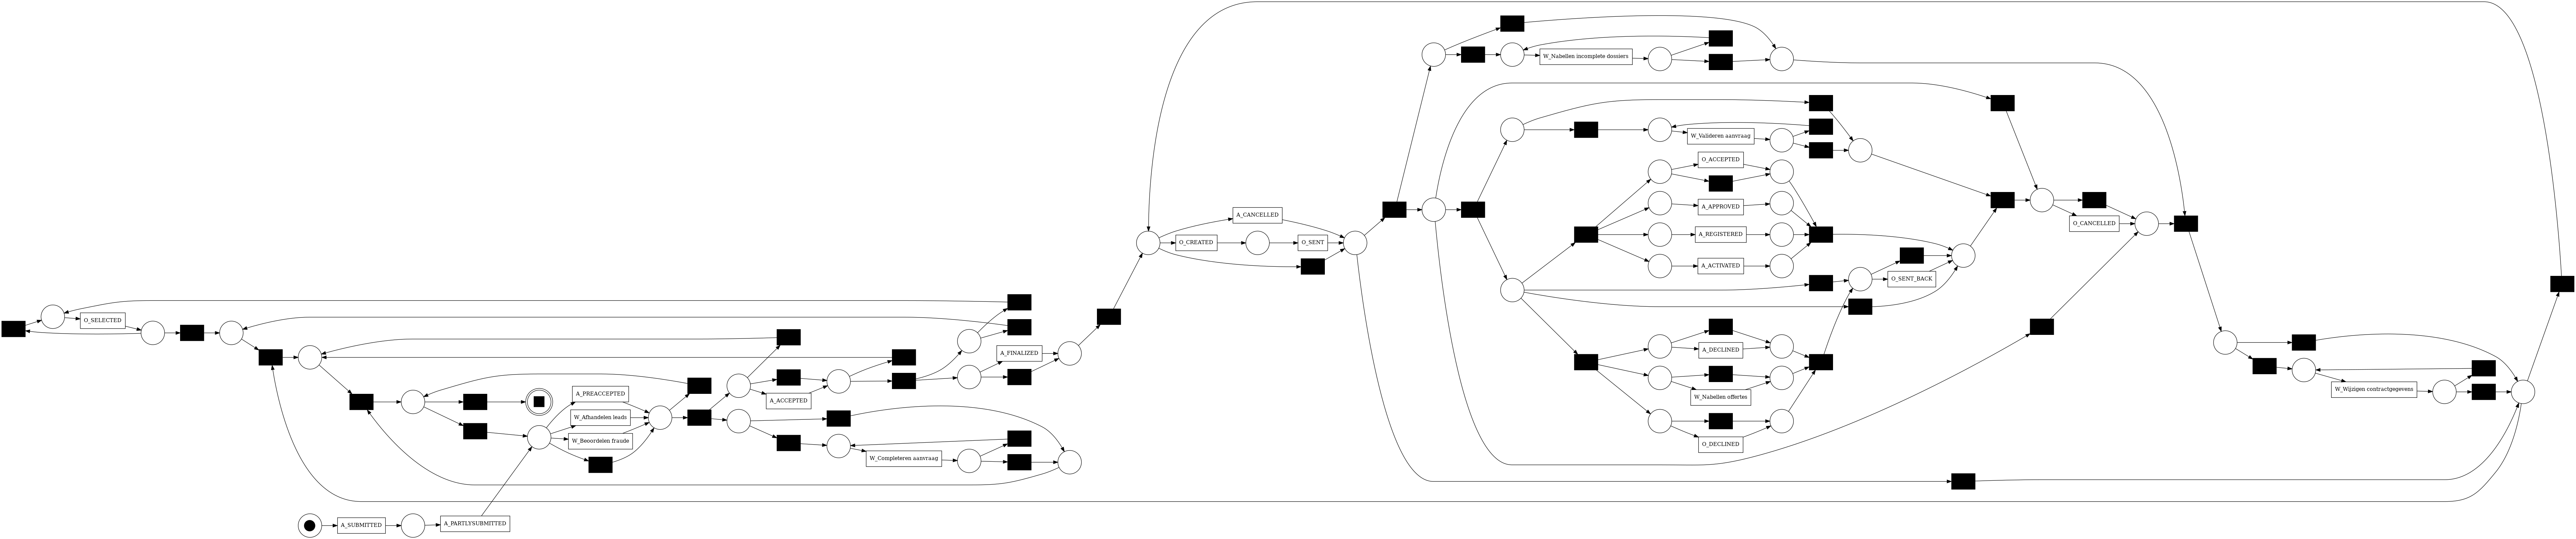

In [10]:
# After discovering the model and evaluating it:
manual_params = {
    "noise_threshold": 0.1
}
net_manual, im_manual, fm_manual = discover_model(log, "inductive_miner", manual_params)
manual_fitness = evaluate_model(net_manual, im_manual, fm_manual, log)
print("Manual configuration fitness:", manual_fitness)
print("AutoML best configuration fitness:", best_value)

# Visualize the Petri net of the manually configured model
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net_manual, im_manual, fm_manual)
pn_visualizer.view(gviz)
